In [1]:
# get data
from urllib.request import urlopen, Request

# parse data from FinViz 
from bs4 import BeautifulSoup
import os
# manipulate and store the data in DataFrames
import pandas as pd
# plot the sentiment on a chart
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK VADER for sentiment analysis on the news headlines
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# take the raw part of the url, we will append the ticker to the end of the link to pull up its data
# Extract data from finviz use the raw url.
finwiz_url = 'https://finviz.com/quote.ashx?t='


hardcode using any ticker for proof of concept then make dynamic on streamlit.
on streamlit: 
   - change aapl to an f string  so end user can dyanmically choose their tickers.
   -  use st.multiselect() so user can pick several tickers as once as a comparison.
   
(Starts to get ugly after 10. tickers. 3 - 5 is cleanest so far)

In [3]:
# Initiate an empty dictionary to hold the news tables from website
news_tables = {}
tickers = ['AAPL']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [4]:
# <td> tag defines the standard cells in the table which are displayed as normal-weight, left-aligned text. 
# <tr> tag defines the table rows.

# Read headlines for 'AAPL' 
aapl = news_tables['AAPL']
# Get all the table rows tagged in HTML with <tr> into 'aapl_tr'
aapl_tr = aapl.findAll('tr')

#Create a list to append the titles
title_list = []
        
# The enumerate() function takes a collection and returns it as an enumerate object.
for index, table_row in enumerate(aapl_tr):
    # Read the text of the element 'a' (Anchor tag) into 'title' 
    title = table_row.a.text
    # Read the text of the element 'td' into 'timestamp' for the timestamp
    timestamp = table_row.td.text.split()
    
    # if the length of 'timestamp' is 1, load 'time' as the only element
    if len(timestamp) == 1:
        time = timestamp[0]
            
    # else load 'date' as the 1st element and 'time' as the second    
    else:
        date = timestamp[0]
        time = timestamp[1]
    ticker = tickers
            
    # Append the title and timestamp to list format. 
    title_list.append([tickers, date, time, title])
    # Create a dataframe using the 'title_list'
    finviz_headlines = pd.DataFrame(title_list, columns=[['ticker', 'date', 'time', 'title']])
finviz_headlines

,ticker,date,time,title
0,[AAPL],Aug-12-22,09:19AM,Dow Jones Futures Rise As Apple Stock Nears Bu...
1,[AAPL],Aug-12-22,08:40AM,Why Index Funds Could Fade
2,[AAPL],Aug-12-22,08:31AM,Apple Rules the S&P 500 With Highest Weighting...
3,[AAPL],Aug-12-22,08:30AM,The Big Winnersand Losers in the Inflation Bill
4,[AAPL],Aug-12-22,08:00AM,Mastercard Faces Retailer Backlash Over Instal...
...,...,...,...,...
95,[AAPL],Aug-08-22,06:17AM,India Seeks to Oust China Firms From Sub-$150 ...
96,[AAPL],Aug-08-22,06:00AM,Why investors should still love stocks like Ap...
97,[AAPL],Aug-08-22,05:52AM,5 Stocks I'll Almost Certainly Still Own in 2030
98,[AAPL],Aug-08-22,05:33AM,Antitrust Bill Targeting Big Tech in Limbo as ...


In [5]:
# Sentiment calculation based on compound score
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

# Sentiment Analysis

In [6]:
# # exmaple, not needed for code
# finviz_headlines['title'].values.tolist()[0]

In [7]:
# # exmaple, not needed for code
# analyzer.polarity_scores(title[0])["neu"]

In [8]:
# Create the sentiment scores DataFrame
analyzer = SentimentIntensityAnalyzer()

title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}


# Get sentiment for the title
for index, row in finviz_headlines.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))
    except AttributeError:
        pass


# Attaching sentiment columns to the News DataFrame
title_sentiment_df = pd.DataFrame(title_sent)
finviz_headlines = finviz_headlines.join(title_sentiment_df)

finviz_headlines.head()

,"(ticker,)","(date,)","(time,)","(title,)",title_compound,title_pos,title_neu,title_neg,title_sent
0,[AAPL],Aug-12-22,09:19AM,Dow Jones Futures Rise As Apple Stock Nears Bu...,0.0000,0.0,1.000,0.000,0
1,[AAPL],Aug-12-22,08:40AM,Why Index Funds Could Fade,0.0000,0.0,1.000,0.000,0
2,[AAPL],Aug-12-22,08:31AM,Apple Rules the S&P 500 With Highest Weighting...,0.0000,0.0,1.000,0.000,0
3,[AAPL],Aug-12-22,08:30AM,The Big Winnersand Losers in the Inflation Bill,-0.5267,0.0,0.673,0.327,-1
4,[AAPL],Aug-12-22,08:00AM,Mastercard Faces Retailer Backlash Over Instal...,0.0000,0.0,1.000,0.000,0


In [9]:
finviz_headlines.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.021025,0.101420,0.819560,0.079040,0.110000
std,0.347155,0.136131,0.169721,0.134551,0.777135
min,-0.743000,0.000000,0.394000,0.000000,-1.000000
25%,-0.032000,0.000000,0.699500,0.000000,-0.250000
50%,0.000000,0.000000,0.809500,0.000000,0.000000
75%,0.273200,0.201000,1.000000,0.134750,1.000000
max,0.812600,0.493000,1.000000,0.537000,1.000000


<AxesSubplot:title={'center':'News Title and Text Sentiment Comparison'}>

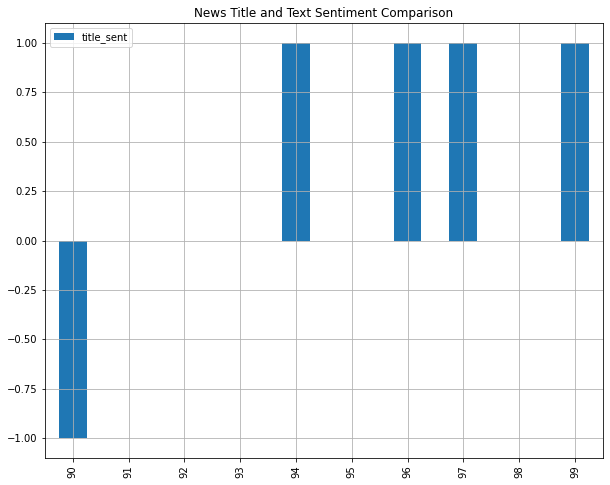

In [10]:
finviz_headlines.tail(10).plot(
    y=["title_sent"],
    kind="bar",
    title="News Title and Text Sentiment Comparison",
    figsize=(10, 8),
    grid=True,
)

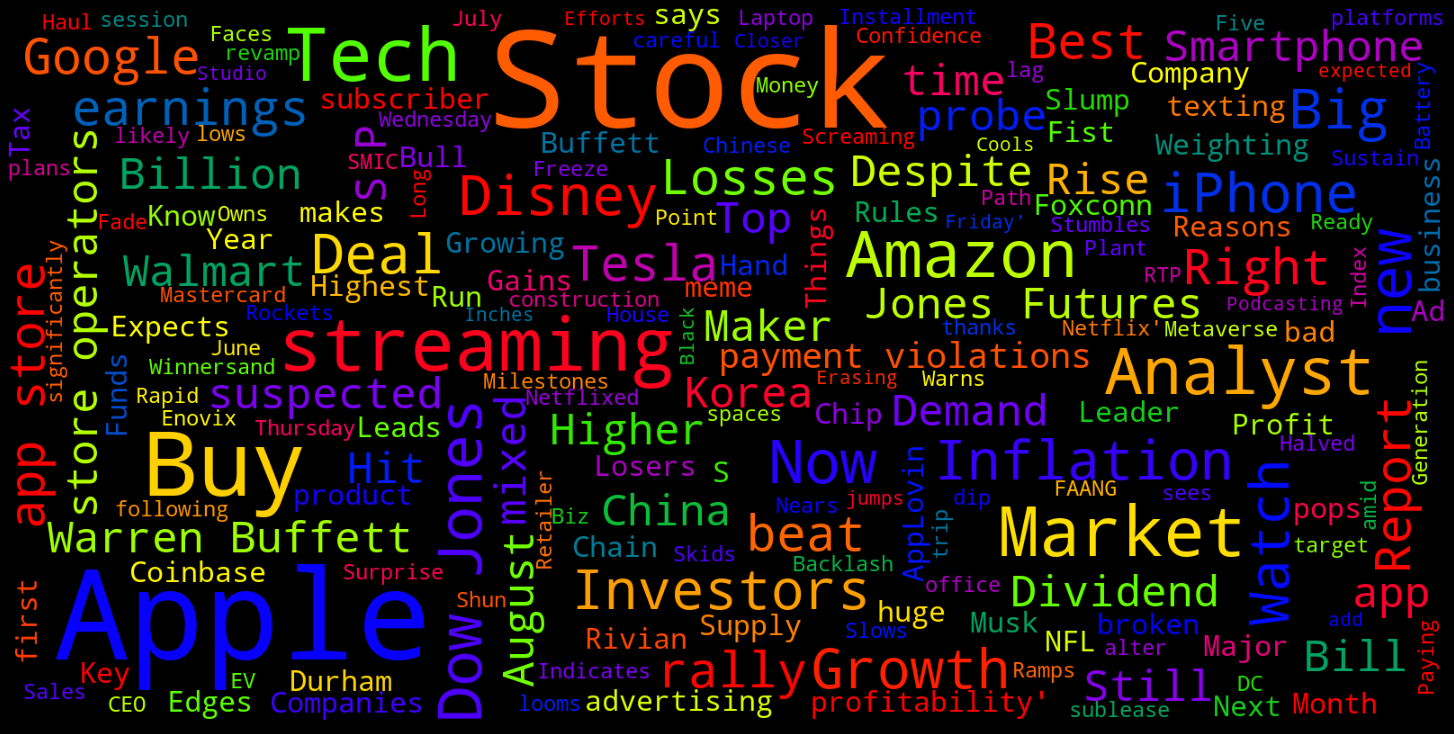

In [12]:
from wordcloud import WordCloud, STOPWORDS
# word cloud visualization
def word_cloud(text):
    stopwords = set(STOPWORDS)
    allWords = ' '.join([title for title in text])
    wordCloud = WordCloud(background_color='black',width = 1600, height = 800,stopwords = stopwords,min_font_size = 20,max_font_size=150,colormap='prism').generate(allWords)
    fig, ax = plt.subplots(figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    ax.axis("off")
    fig.tight_layout(pad=0)
    plt.show()
    # st.pyplot(plt)
    plt

# st.write('Wordcloud for ' + query)
word_cloud(finviz_headlines[('title',)].values)

In [ ]:
polarity_score_df.positive

In [ ]:
# # list of list is finviz_headlines
# # 'title' is the elment in that list - that is the [0]
# for title in finviz_headlines['title'].values.tolist():
#     try:
#         text = title[0]
#         sentiment = analyzer.polarity_scores(text)
#         compound = sentiment["compound"]
#         pos = sentiment["pos"]
#         neu = sentiment["neu"]
#         neg = sentiment["neg"]
        
        
#         df.append({
#             "text": text,
#             "compound": compound,
#             "positive": pos,
#             "negative": neg,
#             "neutral": neu
            
#         })
        
#     except AttributeError:
#         pass
# finviz_headlines    

In [ ]:
# Create DataFrame
polarity_score_df = pd.DataFrame(df)
polarity_score_df

In [ ]:
polarity_score_df.tail(10).plot(
    y=["positive", "negative", "neutral"],
    kind="bar",
    title="Finviz Text Sentiment Comparison",
    figsize=(10, 8),
    grid=True,
)


In [ ]:
#use len function to count lists. 
# st.write("Since " + number_of_days + " days, there have been", len(tweet_list1) ,  "tweets on " + query,'\n*')
print("Positive Sentiment:", '%.2f' % len(polarity_score_df),'\n*')
print("Neutral Sentiment:", '%.2f' % len(polarity_score_df), '\n*')
print("Negative Sentiment:", '%.2f' % len(polarity_score_df), '\n*')